# Online Recommendation System

**IMPORTANT**: This code is written with Python 3 and appropiate installation is required.  Below are the packages called on throughout the program. 

On Amazon, you are looking to purchase a new washing machine and while shopping, you see a recommendation for a dryer.  Why?  These appear from analyzing previous purchase and search data for the company creating a recommendation for relevant products.  

The Online Retail Data Sales data set from the UCI Machine Learning Repository contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.  This retail is having an issue moving products and wants to implement a recommendation system on it’s website allowing for ease of purchase for their customers.  

I will build a model that will give recommendations from previous transactions of the retail.  The company will be able to implement this model on their website that will allow for recommendations of relevant products to their shoppers. As a result, products will move on the website increasing the income of the retail. 


In [40]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
import re
from sklearn.model_selection import train_test_split

In [2]:
#Importing data and setting the index to datetime
os.chdir("C:\\Users\\dixon\\Desktop\\Data Science")
df=pd.read_csv('Online Retail.csv', parse_dates=True, index_col="InvoiceDate")

Observe the data to see if there is any missing values and also obtain the data types. 

In [3]:
#Checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541909 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# 00. Data Wrangling

We first want to observe the raw data to see if there are things that stick out, also looking for patterns. 

In [4]:
#Looking at the data set to observe visual trends
print(df)

                    InvoiceNo StockCode                          Description  \
InvoiceDate                                                                    
2010-12-01 08:26:00    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2010-12-01 08:26:00    536365     71053                  WHITE METAL LANTERN   
2010-12-01 08:26:00    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2010-12-01 08:26:00    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2010-12-01 08:26:00    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   
2010-12-01 08:26:00    536365     22752         SET 7 BABUSHKA NESTING BOXES   
2010-12-01 08:26:00    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER   
2010-12-01 08:28:00    536366     22633               HAND WARMER UNION JACK   
2010-12-01 08:28:00    536366     22632            HAND WARMER RED POLKA DOT   
2010-12-01 08:34:00    536367     84879        ASSORTED COLOUR BIRD ORNAMENT   
2010-12-01 08:34:00    536367     22745 

Strip the letters from the **StockCode** column to make an integer and drop the **promotional items** because they were given (Items that were free, or **UnitPrice = 0**. We only care about items customers wanted to buy.

In [10]:
# Remove data where unit price and quantity is positive. 
df_pos_price = df.loc[lambda df_dropped: (df['UnitPrice'] > 0) & (df['Quantity'] > 0)]
df_pos_price['StockCode'] = df_pos_price['StockCode'].str.strip('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')
df_pos_price['Country'].dropna()
df_pos_price['StockCode'].dropna()
df_pos_price['UnitPrice'].dropna()
print(df_pos_price)
df_pos_price.info()

C:\Users\dixon\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                    InvoiceNo StockCode                          Description  \
InvoiceDate                                                                    
2010-12-01 08:26:00    536365     85123   WHITE HANGING HEART T-LIGHT HOLDER   
2010-12-01 08:26:00    536365     71053                  WHITE METAL LANTERN   
2010-12-01 08:26:00    536365     84406       CREAM CUPID HEARTS COAT HANGER   
2010-12-01 08:26:00    536365     84029  KNITTED UNION FLAG HOT WATER BOTTLE   
2010-12-01 08:26:00    536365     84029       RED WOOLLY HOTTIE WHITE HEART.   
2010-12-01 08:26:00    536365     22752         SET 7 BABUSHKA NESTING BOXES   
2010-12-01 08:26:00    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER   
2010-12-01 08:28:00    536366     22633               HAND WARMER UNION JACK   
2010-12-01 08:28:00    536366     22632            HAND WARMER RED POLKA DOT   
2010-12-01 08:34:00    536367     84879        ASSORTED COLOUR BIRD ORNAMENT   
2010-12-01 08:34:00    536367     22745 

In [6]:
df_pos_price.describe()

,Quantity,UnitPrice,CustomerID
count,530104.000000,530104.000000,397884.000000
mean,10.542037,3.907625,15294.423453
std,155.524124,35.915681,1713.141560
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [13]:
non_uk = df_pos_price.set_index('Country').drop(['United Kingdom'], axis = 0).reset_index()
uk = df_pos_price['Country']

# 1. Visuals EDA

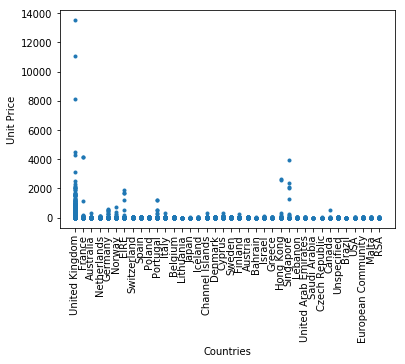

In [14]:
_ = plt.plot(df_pos_price['Country'],df_pos_price['UnitPrice'],marker='.',linestyle='none')
_ = plt.xlabel('Countries')
plt.xticks(rotation=90)
_ = plt.ylabel('Unit Price')
plt.show()

In [15]:
country_purchase = df_pos_price.groupby('Country').InvoiceNo.value_counts()
country_unitprice = df_pos_price.groupby('Country').UnitPrice.value_counts()

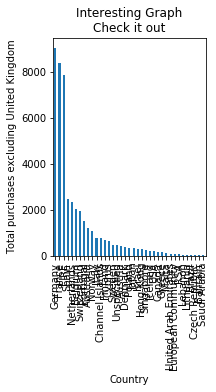

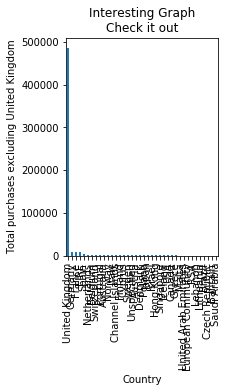

In [16]:
### make 2 bar graphs (one with UK and one without side by side)
plt.subplot(1,2,1); non_uk.Country.value_counts().plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Total purchases excluding United Kingdom')
plt.title('Interesting Graph\nCheck it out')
plt.show()
plt.subplot(1,2,2); df_pos_price.Country.value_counts().plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Total purchases excluding United Kingdom')
plt.title('Interesting Graph\nCheck it out')
plt.show()
### violin plots in seabourn and next to each other
### outlier detection ////remove them for the visual data set


In [17]:
### violin plots in seabourn and next to each other
### outlier detection ////remove them for the visual data set
z = np.abs(stats.zscore(non_uk['Quantity']))
print(z)
threshold = 1
print(np.where(z > 1))
#sns.violinplot(x=non_uk['Country'],y=non_uk['Quantity'])


[0.0722005  0.0722005  0.18159162 ... 0.35078636 0.35078636 0.37193571]
(array([   34,    52,   101, ..., 44826, 44847, 44855], dtype=int64),)


In [18]:
### Test avg mean of unit prce/ctry and avg item sold/contry
### group by country and look at the avgs above
UnitPrice_mean = df_pos_price.groupby('Country').UnitPrice.mean()
UnitPrice_std = df_pos_price.groupby('Country').UnitPrice.std()

In [19]:
total_item = len(df_pos_price.groupby('StockCode'))
df_pos_price.groupby('Country').Quantity.mean()
### country on the y axis and quantity for the x-axis

Country
Australia               70.982234
Austria                 12.263819
Bahrain                 17.444444
Belgium                 11.441162
Brazil                  11.125000
Canada                  18.298013
Channel Islands         12.688503
Cyprus                  10.359935
Czech Republic          26.840000
Denmark                 21.671053
EIRE                    18.653105
European Community       8.316667
Finland                 15.626277
France                  13.334483
Germany                 13.192588
Greece                  10.737931
Hong Kong               16.806338
Iceland                 13.505495
Israel                  14.945763
Italy                   10.701847
Japan                   81.046729
Lebanon                  8.577778
Lithuania               18.628571
Malta                    8.660714
Netherlands             84.934718
Norway                  18.054155
Poland                  11.163636
Portugal                10.831446
RSA                      6.157895
Saudi 

# 2. inferrential stat linear regression (look for p-value and r2)

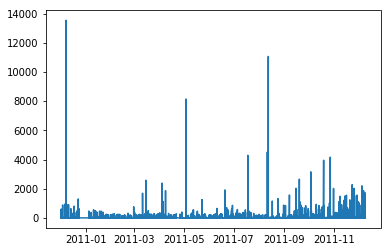

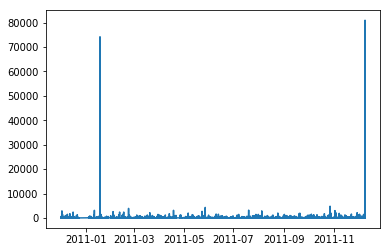

(530104, 2)

In [20]:
df1 = df_pos_price[['UnitPrice','Quantity']]
plt.plot(df1['UnitPrice'])
plt.show()
plt.plot(df1['Quantity'])
plt.show()
df1.shape

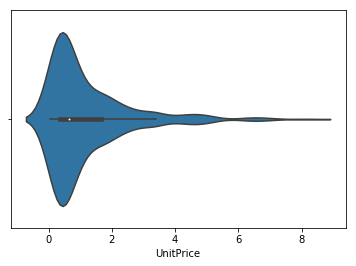

In [21]:
df_price = df1[(np.abs(df1['UnitPrice']-df1['UnitPrice'].mean())>(3*df1['UnitPrice'].std()))]
df_price = df1[(np.abs(df1['UnitPrice']-df1['UnitPrice'].mean())<=(3*df1['UnitPrice'].std()))]
df_price = df1[(np.abs(df1['Quantity']-df1['Quantity'].mean())<=(3*df1['Quantity'].std()))]
df_price = df1[(np.abs(df1['Quantity']-df1['Quantity'].mean())>(3*df1['Quantity'].std()))]
sns.violinplot(df_price['UnitPrice'])

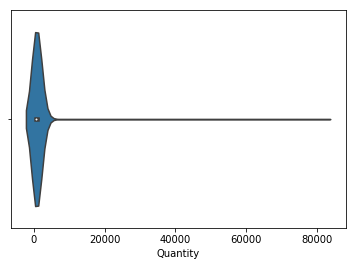

In [22]:
sns.violinplot(df_price['Quantity'])

In [23]:
df_price['intercept']=1
lm=sm.OLS(df_price['UnitPrice'],df_price[['intercept','Quantity']])
slr_results = lm.fit()
slr_results.summary()

C:\Users\dixon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              UnitPrice   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.03389
Date:                Fri, 22 Nov 2019   Prob (F-statistic):              0.854
Time:                        11:35:20   Log-Likelihood:                -885.87
No. Observations:                 522   AIC:                             1776.
Df Residuals:                     520   BIC:                             1784.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1878      0.060     19.958      0.000       1.071       1.305
Quantity    2.232e-06   1.21e-05      0.184      0.854   -2.16e-05     2.6e-05
==============================================================================
Omnibus:                      236.705   Durbin-Watson:                   1.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              920.010
Skew:                           2.124   Prob(JB):                    1.67e-200
Kurtosis:                       7.925   Cond. No.                     5.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
np.random.seed(47)
N_rep = 10000
rep = np.empty(N_rep)

for i in range(N_rep):
        rep[i] = np.mean(np.random.choice(df_pos_price['UnitPrice'], size=len(df_pos_price['UnitPrice'])))

conf_int = np.percentile(rep,[2.5,97.5])
print(conf_int)

[3.81911805 4.01132431]


# 2. Recommendation system

We first need to see how many customers bought items. To give an accurate recommendation, we want to make sure the data we are observing is based on frequent shoppers, and not periodic or one-time shoppers. To do so, we need to first observe the data by the actual **CustomerID** where we then want to see how many items each customer purchased.

In [25]:
#observe the data where we have all column data 
CustomerID = df_pos_price.groupby('CustomerID').count()
print(CustomerID)

            InvoiceNo  StockCode  Description  Quantity  UnitPrice  Country
CustomerID                                                                 
12346.0             1          1            1         1          1        1
12347.0           182        182          182       182        182      182
12348.0            31         31           31        31         31       31
12349.0            73         73           73        73         73       73
12350.0            17         17           17        17         17       17
12352.0            85         85           85        85         85       85
12353.0             4          4            4         4          4        4
12354.0            58         58           58        58         58       58
12355.0            13         13           13        13         13       13
12356.0            59         59           59        59         59       59
12357.0           131        131          131       131        131      131
12358.0     

We now want to remove the customers that did not purchase more than 50 times at the store. We only want customers who have purchased at least 50 times, therefore, we look at the **InvoiceNo** column and manipulate, accordingly. 

            InvoiceNo  StockCode  Description  Quantity  UnitPrice  Country
CustomerID                                                                 
12347.0           182        182          182       182        182      182
12349.0            73         73           73        73         73       73
12352.0            85         85           85        85         85       85
12354.0            58         58           58        58         58       58
12356.0            59         59           59        59         59       59
12357.0           131        131          131       131        131      131
12359.0           248        248          248       248        248      248
12360.0           129        129          129       129        129      129
12362.0           266        266          266       266        266      266
12364.0            85         85           85        85         85       85
12370.0           167        167          167       167        167      167
12371.0     

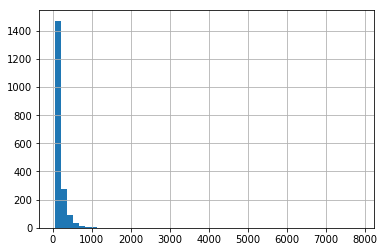

In [26]:
# Customers less than 50 orders
df_clean=CustomerID.loc[lambda CustomerID: CustomerID['InvoiceNo'] > 50]
print(df_clean)
df_clean.reset_index().StockCode.hist(bins=50)

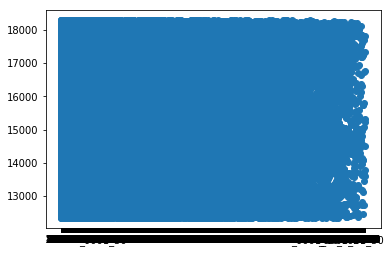

In [43]:
cluster1=df_pos_price[['StockCode','CustomerID']]
X_train, X_test, y_train, y_test = train_test_split(cluster1['StockCode'], cluster1['CustomerID'], test_size=0.33, random_state=42)
plt.scatter(X_test,y_test)
plt.show()

Create a DataFrame that indexed by the **StockCode** and use the **CustomerID** as the columns where we figured the values to be the **Quantity** shared between them. Normalize the data.

In [44]:
# New DataFrame created to view the relationship between the custumer and the items purchased filling NaN with 0.
cluster1 = df_clean.pivot_table(index='StockCode', columns='CustomerID', values='Quantity', aggfunc = np.sum).fillna(value=0)
# Normalizing the data.
cluster1_minmax = MinMaxScaler().fit_transform(df_clean)
print(cluster1)

CustomerID  12347.0  12349.0  12352.0  12354.0  12356.0  12357.0  12359.0  \
StockCode                                                                   
51              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
52              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
53              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
54              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
55              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
56              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
57              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
58              0.0      0.0      0.0     58.0      0.0      0.0      0.0   
59              0.0      0.0      0.0      0.0     59.0      0.0      0.0   
60              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
61              0.0      0.0      0.0      0.0      0.0      0.0      0.0   

C:\Users\dixon\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Figured out the *optimal* **k** (number of clusters) for the DataFrame using the **Elbow Method** by obtaining initializing a range of values for **k**. We then plot this data to observe the plot for the **Elbow Point** which gives the optimal **k**. 

In [22]:
# Gave a range for K to obtain the list of K values
Sum_of_squared = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster1_minmax)
    Sum_of_squared.append(km.inertia_)

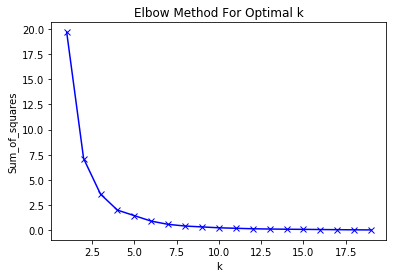

In [23]:
# Create the plot that will produce the elbow plot to give optimal value of k.
plt.plot(K, Sum_of_squared, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squares')
plt.title('Elbow Method For Optimal k')
plt.show()

Create a DataFrame that indexed by the **CustomerID** and use the **StockCode** as the columns where we figured the values to be the **Quantity** shared between them. Normalize the data.

In [24]:
# New DataFrame created to view the relationship between the custumer and the items purchased filling NaN with 0.
cluster2 = df_clean.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc = np.sum).fillna(value=0)
# Normalized the data.
cluster2_minmax = MinMaxScaler().fit_transform(df_clean)
print(cluster2_minmax)

[[0.01680349 0.01680349 0.01680349 0.01680349 0.01680349 0.01680349]
 [0.00282196 0.00282196 0.00282196 0.00282196 0.00282196 0.00282196]
 [0.00436121 0.00436121 0.00436121 0.00436121 0.00436121 0.00436121]
 ...
 [0.01475115 0.01475115 0.01475115 0.01475115 0.01475115 0.01475115]
 [0.09043099 0.09043099 0.09043099 0.09043099 0.09043099 0.09043099]
 [0.00243715 0.00243715 0.00243715 0.00243715 0.00243715 0.00243715]]


C:\Users\dixon\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [25]:
kmeans = KMeans(n_clusters=40)
kmeans.fit(cluster2)
labels = kmeans.predict(cluster2) ## this is the cluster number rows==(custid,clusternum)
print(labels)
print(pd.DataFrame(labels).mean())
df = np.transpose(pd.DataFrame([cluster2.reset_index().CustomerID,labels]))
### df_clean=CustomerID.loc[lambda CustomerID: CustomerID['InvoiceNo'] > 50]
print(df)

[26 26 26 ... 26 26 26]
0    25.552935
dtype: float64
      CustomerID  Unnamed 0
0        12347.0       26.0
1        12349.0       26.0
2        12352.0       26.0
3        12354.0       26.0
4        12356.0       26.0
5        12357.0       26.0
6        12359.0       26.0
7        12360.0       26.0
8        12362.0       26.0
9        12364.0       26.0
10       12370.0       26.0
11       12371.0       26.0
12       12372.0       26.0
13       12377.0       26.0
14       12378.0       26.0
15       12380.0       26.0
16       12381.0       26.0
17       12383.0       26.0
18       12388.0       26.0
19       12391.0       26.0
20       12393.0       26.0
21       12395.0       26.0
22       12397.0       26.0
23       12398.0       26.0
24       12399.0       26.0
25       12405.0       26.0
26       12406.0       26.0
27       12407.0       26.0
28       12408.0       26.0
29       12409.0       26.0
...          ...        ...
1878     18179.0       26.0
1879     18180.0      

## 2.1 Recommendation (Clustering)

Figured out the *optimal* **k** (number of clusters) for the DataFrame using the **Elbow Method** by obtaining initializing a range of values for **k**. We then plot this data to observe the plot for the **Elbow Point** which gives the optimal **k**. 

In [26]:
# Gave a range for K to obtain the set of K values
Sum_of_squared2 = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster2_minmax)
    Sum_of_squared2.append(km.inertia_)
print(Sum_of_squared2)

[19.654386301617127, 7.131771146602875, 3.601365940706632, 2.018368630758498, 1.4705880136312974, 0.9243842097817921, 0.6198965865318321, 0.43918344982138025, 0.3509018905147269, 0.26335424994525675, 0.21273157531590006, 0.16876252899170543, 0.14396930396677463, 0.12151889410851055, 0.10509450199767957, 0.09167058060621663, 0.07828692037933291, 0.0645875945628146, 0.0545357065452494]


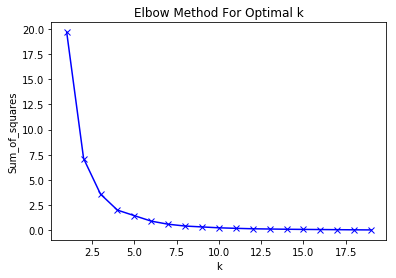

In [27]:
# Create the plot that will produce the elbow plot to give optimal value of k.
plt.plot(K, Sum_of_squared2, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squares')
plt.title('Elbow Method For Optimal k')
plt.show()

From observations above, it seems the the optimal K=10. We now can use this to give the number of recommended products of most purchased. 

In [28]:
similar_to_contact = cluster2.corrwith(cluster1).dropna()
similar_to_contact

Series([], dtype: float64)

## 2.2 Recommendation (Most Purchased item)

We want to figure out how many of each product was purchased. Therefore, we need to group our original data by the **StockCode** to see how many customers purchased the item. This will allow us to see which item was purchased the most of all items. Once we have this data, we now recommend this item to all customers. 

In [29]:
rec1 = pd.DataFrame(df_pos_price.groupby('StockCode').count().sort_values(by='CustomerID',ascending=False))
most_purchased = rec1['CustomerID'].head()
print(most_purchased)

StockCode
85123A    2035
22423     1723
85099B    1618
84879     1408
47566     1396
Name: CustomerID, dtype: int64


## 2.3 Recommendation (New Items purchased)

Extract the products that only **one** customer purchased. These products that are considered **new** since it has no purchase history. Recommend this product to all customers.

In [30]:
new_prod = rec1.loc[lambda rec1: rec1['CustomerID'] <= 10].sort_values(by = 'CustomerID', ascending = False)
new_product = new_prod['CustomerID']
print(new_product)

StockCode
90201B    10
22871     10
84796A    10
85055     10
23024     10
84925D    10
84466     10
22486     10
85045     10
17090A    10
90199C    10
85095     10
90082A    10
90162B    10
84816     10
47591B    10
21761     10
81950B    10
84800S    10
20696     10
82011A    10
90198A    10
79337     10
23478     10
84247K    10
84631     10
21413     10
85130A    10
23442     10
85019C    10
          ..
21120      0
51014c     0
20960      0
20954      0
84923      0
84993a     0
18098c     0
90126A     0
21082      0
21144      0
37474      0
85040a     0
37491A     0
85039a     0
85036b     0
84997c     0
85036a     0
85035c     0
85035b     0
85035a     0
85034b     0
85034a     0
46776a     0
46776b     0
46776e     0
46776f     0
85014b     0
85014a     0
84997d     0
m          0
Name: CustomerID, Length: 1091, dtype: int64


In [31]:
rec1 = rec1.sample(frac = 1) 
df_train = rec1.head(2734).reset_index().sort_values('InvoiceNo',ascending=False)
df_test = rec1.tail(304).reset_index().sort_values('InvoiceNo', ascending = False)
print(df_train[df_train['StockCode'].isin(['85123','22423','20725'])])
print(df_test)

     StockCode  InvoiceNo  Description  Quantity  UnitPrice  CustomerID  \
2702     22423       2017         2017      2017       2017        1723   

      Country  
2702     2017  
    StockCode  InvoiceNo  Description  Quantity  UnitPrice  CustomerID  \
267     84879       1489         1489      1489       1489        1408   
27      22720       1399         1399      1399       1399        1159   
116     20727       1328         1328      1328       1328        1105   
106     22666       1126         1126      1126       1126         843   
200     22993       1102         1102      1102       1102         893   
228     22178       1047         1047      1047       1047         825   
140     20724       1047         1047      1047       1047         751   
4       22077        980          980       980        980         751   
84      23301        926          926       926        926         768   
290     22090        804          804       804        804         573   
149

In [ ]:
print(df_test.sum())

In [ ]:
P = df_train.loc[lambda df_train: df_train['CustomerID'] >= 750]
most_purchased = pd.DataFrame(P, columns = ['CustomerID'])
print(most_purchased)